In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader


# import torch.optim as optim
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.expanduser("~/DON")))
'''
import argparse
parser = argparse.ArgumentParser(description="DeepONet with configurable parameters.")
parser.add_argument('--problem', type=str, default="heat", help='Problem to solve')
parser.add_argument('--var', type=int, default=0, help='Variant of DeepONet')
parser.add_argument('--struct', type=int, default=2, help='Structure of DeepONet')
parser.add_argument('--sensor', type=int, default=50, help='Number of sensors')
parser.add_argument('--boundary_parameter', type=float, default=0, help='Weight parameter for border conditions')
# 解析命令行参数
args = parser.parse_args()
var = args.var
struct = args.struct
n_points = args.sensor
boundary_parameter = args.boundary_parameter
'''
problem = "heat"
var = 0
struct = 2
n_points = 50
boundary_parameter = 0


In [2]:
# In this cell, we define the configurable parameters for the DeepONet

time_limit = 1
time_step = 0.01

if problem=="heat":
    time_start = time_step
    total_time_steps = int(time_limit/time_step)
    from utilities.tools import get_cell_centers
    evaluating_points = get_cell_centers(n_points=n_points)
elif problem=="burgers":
    time_start = 0
    total_time_steps = (int(time_limit/time_step)+1)
    evaluating_points = np.linspace(0, 1, n_points)

evaluating_points = np.around(evaluating_points, decimals=2)

total_sample = 500
border = int(total_sample * 4 / 5) # 设置训练集和测试集的边界
batch_size = 20


# Hyperparameters
branch_input_dim = n_points  # Number of points to represent the original function
trunk_input_dim = 2     # Coordinate where we evaluate the transformed function

# Define the dictionary mapping struct values to neural network structures
if var!=6:
    structures = {
        1: {'hidden_dims': [100, 100, 100, 100], 'output_dim': 50},
        2: {'hidden_dims': [200, 200, 200, 200], 'output_dim': 50}
    }

    # Get the configuration based on the struct value
    config = structures.get(struct, {'hidden_dims': [], 'output_dim': 0})

    hidden_dims = config['hidden_dims']
    output_dim = config['output_dim']
elif var==6:
    structure_params = {
        1: (3, 3, 100, 50),
        2: (3, 3, 200, 50),
    }
    if struct in structure_params:
        branch_depth, trunk_depth, hidden_dim, output_dim = structure_params[struct]
    else:
        raise ValueError("Invalid structure type")

In [3]:
# In this cell, we import the function to get the cell centers of a 1D mesh.
# Also, we set up the spatial and temporal grid points for the training and testing datasets.
# This is the so-called y_expanded tensor.
time_steps = np.arange(time_start, time_limit+time_step, time_step)
time_steps = np.around(time_steps, decimals=2)

Y1, Y2 = np.meshgrid(evaluating_points, time_steps)  # 第一个变量进行行展开，第二个变量进行列展开

y = np.column_stack([Y2.ravel(),Y1.ravel()]) 
# 先将 Y2 和 Y1 进行展开，然后将展开后的两个向量进行列合并

y_tensor = torch.tensor(y, dtype=torch.float)
print(f"The dimension of y_tensor is {y_tensor.shape}.")
y_expanded = y_tensor.unsqueeze(0).expand(total_sample, -1, -1)
print(f"The dimension of y_expanded is {y_expanded.shape} after expanding.")

The dimension of y_tensor is torch.Size([5000, 2]).
The dimension of y_expanded is torch.Size([500, 5000, 2]) after expanding.


In [4]:
# In this cell, we load the initial conditions and solutions from the saved files.

# Define the directory where you want to save the file
from pathlib import Path
# Get the current directory
current_dir = Path.cwd()
#data_directory = os.path.join(current_dir.parent, 'data')
data_directory = os.path.join(current_dir, 'data')
initials_name = f'{problem}_initials_{len(evaluating_points)}.npy'
solutions_name = f'{problem}_solutions_{len(evaluating_points)}.npy'

# Define the file paths
initials_path = os.path.join(data_directory, initials_name)
solutions_path = os.path.join(data_directory, solutions_name)

# Load the data
initials = np.load(initials_path)
solutions = np.load(solutions_path)

print(f"The dimensions of the initial conditions are: {initials.shape}")
print(f"The dimensions of the solutions are: {solutions.shape}")

The dimensions of the initial conditions are: (500, 50)
The dimensions of the solutions are: (500, 100, 50)


In [5]:
# In this cell, we arrange the initial conditions into the desired format for training the DeepONet.
# This is the so-called u_expanded tensor.
u_tensor = torch.tensor(initials, dtype=torch.float)
print(f"The dimension of u_tensor is {u_tensor.shape}.")

u_expanded = u_tensor.unsqueeze(1) # u_expanded: tensor[total_sample, 1, n_points]
u_expanded = u_expanded.expand(-1, total_time_steps*n_points, -1) # u_expanded: tensor[total_sample, total_time_steps*n_points, n_points]
print(f"The dimension of u_expanded is {u_expanded.shape} after expanding.")

The dimension of u_tensor is torch.Size([500, 50]).
The dimension of u_expanded is torch.Size([500, 5000, 50]) after expanding.


In [6]:
# I have a tensor of shape (total_sample, n_points) representing the initial conditions. In this cell, I wanted to expand it to (total_sample, total_time_steps*n_points) by repeating the initial conditions for each time step.

# Assuming u_tensor is the tensor of shape (total_sample, n_points)
# Expand the tensor to (total_sample, total_time_steps*n_points)
u_corresponding = u_tensor.repeat(1, total_time_steps)
u_corresponding = u_corresponding.unsqueeze(2)
#(u_corresponding.shape)

if var==2 or var==3:
    y_expanded = torch.cat((y_expanded, u_corresponding), dim=-1)

In [7]:
# In this cell, we arrange the solutions into the desired format for training the DeepONet.
# This is the so-called s_expanded tensor.

solutions_linear = np.zeros((total_sample, total_time_steps*n_points))

for i in range(total_sample):
    solutions_linear[i] = solutions[i].flatten()

# solutions is a 3D array of shape (total_sample, total_time_steps, n_points)
print(f"The loaded solution dataset has dimension {solutions.shape},\n\t while the arranged linearized dataset has dimension {solutions_linear.shape}.")

s_tensor  = torch.tensor(solutions_linear, dtype=torch.float) # s_tensor: tensor[total_sample, total_time_steps*n_points]
s_expanded  = s_tensor.unsqueeze(2) # s_expanded: tensor[total_sample, total_time_steps*n_points, 1]

print(f"The dimension of s_tensor is {s_tensor.shape}.")
print(f"The dimension of s_expanded is {s_expanded.shape} after expanding.")

The loaded solution dataset has dimension (500, 100, 50),
	 while the arranged linearized dataset has dimension (500, 5000).
The dimension of s_tensor is torch.Size([500, 5000]).
The dimension of s_expanded is torch.Size([500, 5000, 1]) after expanding.


In [8]:
from utilities.tools import CustomDataset_data as CustomDataset

train_set = CustomDataset(u_expanded[:border], y_expanded[:border], s_expanded[:border])
test_set = CustomDataset(u_expanded[border:], y_expanded[border:], s_expanded[border:])

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)

In [9]:
# In this cell, we import the neural network models and the loss functions.

from utilities.DON_Variants import DeepONets
from utilities.loss_fns import loss_fn_1d as loss_fn

In [10]:
# In this cell, we set up the model and load the trained parameters

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if var!=6:
    model = DeepONets[var](branch_input_dim, trunk_input_dim, hidden_dims, output_dim).to(device)
elif var==6:
    model = DeepONets[var](branch_input_dim, branch_depth, trunk_input_dim, trunk_depth, hidden_dim, output_dim).to(device)


# Load Model Parameters
model_para_file = os.path.join(model_train_directory, f"{problem}_Var{var}_Struct{struct}_Sensor{n_points}_Batch{batch_size}-best.pth")
model.load_state_dict(torch.load(model_para_file, map_location=torch.device(device)))
# Turn to evaluation mode
model.eval()

C:\Users\weiz828\AppData\Local\Temp\ipykernel_22092\3190755952.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_para_file, map_loc

DeepONet_0(
  (branch_net): BranchNet(
    (fc): Sequential(
      (0): Linear(in_features=50, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=50, bias=True)
    )
  )
  (trunk_net): TrunkNet(
    (fc): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=50, bias=True)
    )
  )
)

In [11]:
# In this cell, we load the .npy file containing the training error for each epoch

error_array_file = os.path.join(model_train_directory, f"{problem}_Var{var}_Struct{struct}_Sensor{n_points}_Batch{batch_size}-final.npy")
error_array_loaded = np.load(error_array_file)

error_epochs = np.mean(error_array_loaded, axis=-1)

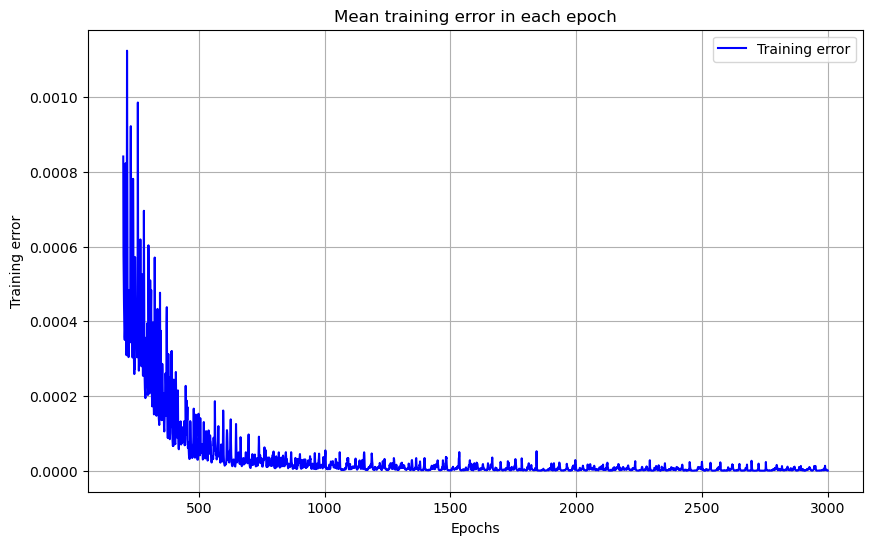

In [12]:
# In this cell, we plot the training error for each epoch

def plot_training_error(error_epochs, custom_begin=100):
    """
    Plot the training error for each epoch.

    Parameters:
    - error_epochs: Array of training errors for each epoch.
    - custom_begin: Epoch to start plotting from (default is 100).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(custom_begin, len(error_epochs)), error_epochs[custom_begin:], label='Training error', color='b')
    plt.title('Mean training error in each epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Training error')
    plt.legend()
    plt.grid(True)
    
    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Struct{struct}_Sensor{n_points}_Batch{batch_size}_Epochs.png")
    # 文件名格式

    # 保存图像为 PNG 文件
    plt.savefig(output_image)
    
    plt.show()
    
plot_training_error(error_epochs, custom_begin=200)

In [13]:
# # In this cell, we compute training and testing loss for the model

def compute_loss(model, data_loader, device, description="Computing loss"):
    """
    Compute the loss for a given dataset using the trained model.

    Parameters:
    - model: The trained model.
    - data_loader: DataLoader for the dataset (train or test).
    - device: Device to run the computations on (CPU or GPU).
    - description: Description for the tqdm progress bar.

    Returns:
    - average_loss: The average loss over the dataset.
    """
    total_loss = 0
    with torch.no_grad():
        for input1_batch, input2_batch, target_batch in tqdm(data_loader, desc=description):
            input1_batch = input1_batch.to(device)
            input2_batch = input2_batch.to(device)
            target_batch = target_batch.to(device)
            outputs = model(input1_batch, input2_batch)
            loss = loss_fn(outputs, target_batch, boundary_parameter, total_time_steps, n_points)
            total_loss += loss.item()
            del input1_batch, input2_batch, target_batch, outputs
            torch.cuda.empty_cache()  # Release cache for the current batch
    average_loss = total_loss / len(data_loader)
    return average_loss

# Compute training loss
train_loss = compute_loss(model, train_loader, device, description="Computing training loss")
print(f"Train loss: {train_loss}")

# Compute testing loss
test_loss = compute_loss(model, test_loader, device, description="Computing testing loss")
print(f"Test loss: {test_loss}")

# Write the losses to a file
with open(model_stat_file_path, 'w') as f:
    f.write(f"Train loss: {train_loss}\n")
    f.write(f"Test loss: {test_loss}\n")

Computing training loss:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 2.769393596224745e-07


Computing testing loss:   0%|          | 0/5 [00:00<?, ?it/s]

Test loss: 3.9305909353970493e-07


In [14]:
# In this cell, we compute the predictions for the entire dataset using the trained model

def compute_predictions(model, u_expanded, y_expanded, total_sample, total_time_steps, n_points, batch_size, device):
    """
    Compute predictions for the entire dataset using the trained model.

    Parameters:
    - model: The trained model.
    - u_expanded: Expanded tensor of initial conditions.
    - y_expanded: Expanded tensor of spatial and temporal grid points.
    - total_sample: Total number of samples.
    - total_time_steps: Total number of time steps.
    - n_points: Number of spatial points.
    - batch_size: Batch size for processing.
    - device: Device to run the computations on (CPU or GPU).

    Returns:
    - all_predictions: Tensor containing predictions for the entire dataset.
    """
    all_predictions = torch.zeros((total_sample, total_time_steps * n_points))

    with torch.no_grad():
        for i in tqdm(range(0, total_sample, batch_size), desc="Computing predictions"):
            u_batch = u_expanded[i:i + batch_size].to(device)
            y_batch = y_expanded[i:i + batch_size].to(device)
            
            prediction = model(u_batch, y_batch).squeeze()
            all_predictions[i:i + batch_size] = prediction.cpu()  # Store predictions and move to CPU
            
            del u_batch, y_batch, prediction
            torch.cuda.empty_cache()  # Release cache for the current batch

    return all_predictions

all_predictions = compute_predictions(model, u_expanded, y_expanded, total_sample, total_time_steps, n_points, batch_size, device)

Computing predictions:   0%|          | 0/25 [00:00<?, ?it/s]

In [16]:
# In this cell, we compute the relative L2 error for the entire dataset, including training and testing sets

# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

absolute_err = torch.zeros((total_sample,total_time_steps*n_points))
absolute_l2_err = np.zeros(total_sample)
relative_l2_err = np.zeros(total_sample)
for i in tqdm(range(total_sample), desc="Computing relative l2 error for the entire dataset"):
    absolute_err[i] = abs(all_predictions[i] - s_tensor[i])
    absolute_l2_err[i] = l2_norm_last_coord_torch(absolute_err[i])
    relative_l2_err[i] = absolute_l2_err[i] / l2_norm_last_coord_torch(s_tensor[i])

train_relative_l2_err = relative_l2_err[:border]
test_relative_l2_err = relative_l2_err[border:]

Computing relative l2 error for the entire dataset:   0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
# In this cell, we compute the key statistics of the relative L2 error for the training and testing sets, and compare the statistics

# 计算张量的统计量
def get_statistics(array):
    stats = {
        'mean': np.mean(array),
        'std': np.std(array),
        'min': np.min(array),
        'median': np.median(array),
        'max': np.max(array)
    }
    return stats

# 比较两个张量的统计量
def compare_statistics(statistics1, statistics2, output_file):
    comparison = {}
    for key in statistics1.keys():
        comparison[key] = {
            'train': statistics1[key],
            'test': statistics2[key],
            'difference': statistics1[key] - statistics2[key]  # 计算差异
        }

    with open(output_file, 'a') as f:
        f.write("\nComparison of Train and Test Statistics:\n")
        print("\nComparison of Train and Test Statistics:\n")
        for key, values in comparison.items():
            f.write(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}\n")
            print(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}")

# 获取训练和测试张量的统计量
train_statistics = get_statistics(train_relative_l2_err)
test_statistics = get_statistics(test_relative_l2_err)

# 比较两个统计量并打印结果
compare_statistics(train_statistics, test_statistics, model_stat_file_path)


Comparison of Train and Test Statistics:

mean: Train = 0.0060812834848184135, Test = 0.006306520062498749, Absolute Difference = 0.00022523657768033518
std: Train = 0.004468236377968975, Test = 0.003843200858060554, Absolute Difference = 0.0006250355199084209
min: Train = 0.0018026618054136634, Test = 0.001999939326196909, Absolute Difference = 0.00019727752078324556
median: Train = 0.004595329752191901, Test = 0.00478072022087872, Absolute Difference = 0.00018539046868681908
max: Train = 0.04095815122127533, Test = 0.017850710079073906, Absolute Difference = 0.023107441142201424


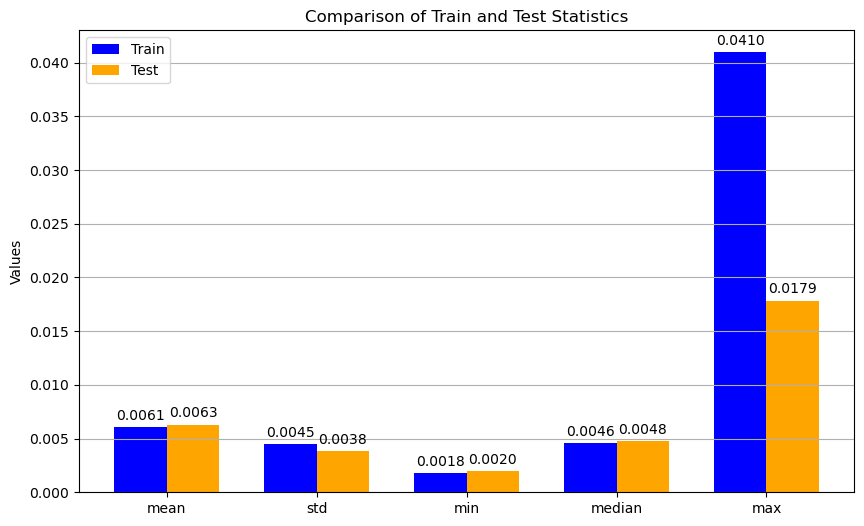

In [18]:
# In this cell, we plot the key statistics of the relative L2 error for the training and testing sets in a bar chart

import matplotlib.pyplot as plt
import numpy as np

def plot_statistics_comparison(train_statistics, test_statistics):
    """
    Plot the comparison of train and test statistics in a bar chart.

    Parameters:
    - train_statistics: Dictionary of training statistics.
    - test_statistics: Dictionary of testing statistics.
    """
    # Extract statistics data for plotting
    labels = list(train_statistics.keys())
    train_values = [train_statistics[key] for key in labels]
    test_values = [test_statistics[key] for key in labels]

    # Set up the plot
    bar_positions = np.arange(len(labels))  # Number of labels
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(bar_positions - width/2, train_values, width, label='Train', color='b')
    bars2 = ax.bar(bar_positions + width/2, test_values, width, label='Test', color='orange')

    # Add labels and title
    ax.set_ylabel('Values')
    ax.set_title('Comparison of Train and Test Statistics')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add data labels with more decimal points
    def add_data_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.4f}',  # Keep four decimal places
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3),  # Offset upwards
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_data_labels(bars1)
    add_data_labels(bars2)

    plt.grid(axis='y')

    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Struct{struct}_Sensor{n_points}_Batch{batch_size}_Stat.png")
    # 文件名格式
    # 保存图像为 PNG 文件
    plt.savefig(output_image)

    plt.show()
    
plot_statistics_comparison(train_statistics, test_statistics)

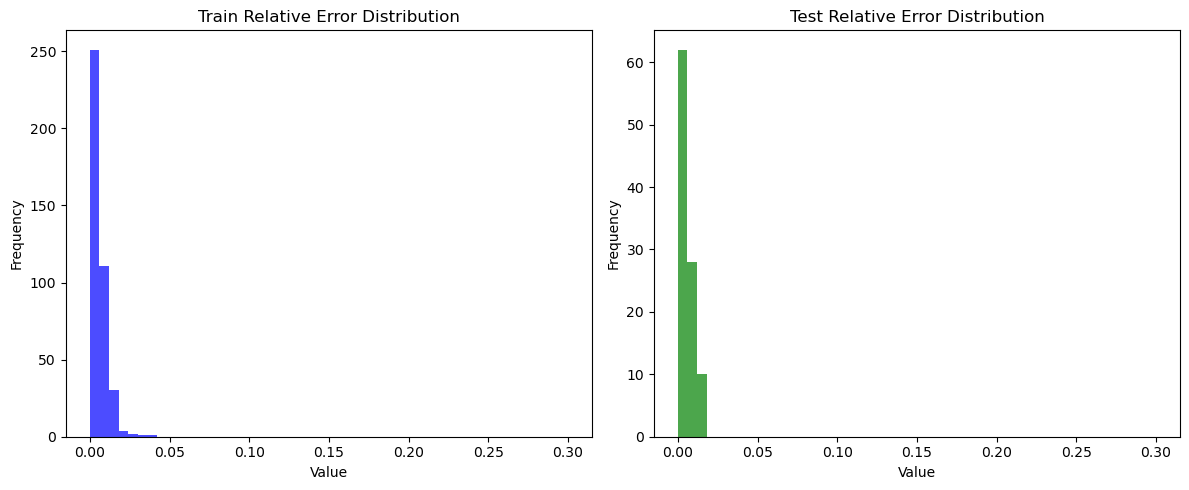

In [19]:
# In this cell, we plot the distribution of the relative L2 error for the training and testing sets

def plot_dual_histogram(array1, array2, bins=50, x_range=(0, 0.3), color1='blue', color2='green',
                        title1='Train Relative Error Distribution', title2='Test Relative Error Distribution'):
    """
    并排绘制两个 1 维数组的直方图。
    参数:
    - array1: 第一个数组的数据。
    - array2: 第二个数组的数据。
    - bins: 直方图的条数。
    - x_range: 直方图的范围。
    - color1: 第一个直方图的颜色。
    - color2: 第二个直方图的颜色。
    - title1: 第一个直方图的标题。
    - title2: 第二个直方图的标题。
    """
    # 创建两个子图，分别用于绘制两个张量的直方图
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 绘制第一个张量的直方图
    axs[0].hist(array1, bins=bins, range = x_range, alpha=0.7, color=color1)
    axs[0].set_title(title1)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # 绘制第二个张量的直方图
    axs[1].hist(array2, bins=bins, range = x_range, alpha=0.7, color=color2)
    axs[1].set_title(title2)
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')

    # 显示并排的图像
    plt.tight_layout()
    
    output_image = os.path.join(model_train_directory, f"{problem}_Var{var}_Struct{struct}_Sensor{n_points}_Batch{batch_size}_Hist.png")
    # 文件名格式

    # 保存图像为 PNG 文件
    plt.savefig(output_image)

    plt.show()
# 使用示例
plot_dual_histogram(train_relative_l2_err, test_relative_l2_err)